In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
import numpy as np
step = "journey_start_yearmonth"
MINUTES = 60 * 1000

plt.rc('pgf', rcfonts=False, preamble=r'''
    \usepackage[fontsize=10pt]{scrextend}
    \usepackage{unicode-math}
''') # https://github.com/matplotlib/matplotlib/issues/26892

In [2]:
restricted_rpc = pd.read_pickle("data/restricted_rpc.p")
routes_car_df = pd.read_pickle("data/alternative_routes/car.p")
routes_bike_df = pd.read_pickle("data/alternative_routes/bike.p")
routes_pt_df = pd.read_pickle("data/alternative_routes/pt.p")

Merge all this data for the comparison

In [3]:
reindexed = routes_car_df.set_index(
    [
        "journey_start_lon",
        "journey_start_lat",
        "journey_end_lon",
        "journey_end_lat",
    ]
)
merged = pd.merge(
    restricted_rpc,
    reindexed.add_suffix("_car"),
    left_on=[
        "journey_start_lon",
        "journey_start_lat",
        "journey_end_lon",
        "journey_end_lat",
    ],
    how="left",
    right_index=True,
)


reindexed = routes_bike_df.set_index(
    [
        "journey_start_lon",
        "journey_start_lat",
        "journey_end_lon",
        "journey_end_lat",
    ]
)
merged = pd.merge(
    merged,
    reindexed.add_suffix("_bike"),
    left_on=[
        "journey_start_lon",
        "journey_start_lat",
        "journey_end_lon",
        "journey_end_lat",
    ],
    how="left",
    right_index=True,
)

reindexed = routes_pt_df.set_index(
    [
        "journey_start_lon",
        "journey_start_lat",
        "journey_end_lon",
        "journey_end_lat",
        "journey_end_datetime_norm",
    ]
)
merged = pd.merge(
    merged,
    reindexed.add_suffix("_pt"),
    left_on=[
        "journey_start_lon",
        "journey_start_lat",
        "journey_end_lon",
        "journey_end_lat",
        "journey_end_datetime_norm",
    ],
    how="left",
    right_index=True,
)

Normalize trip durations to minutes:

In [4]:
merged["time_car_min"] = merged["time_car"] / 60000
merged["time_pt_min"] = merged["time_pt"] / 60000
merged["time_bike_min"] = merged["time_bike"] / 60000

x_max = merged["time_car_min"].max()
y_max = max(merged["time_pt_min"].max(), merged["time_bike_min"].max())

Keep only relevant public transport trips for comparison.
In fact, trips with no transfer (`transfers_pt = -1`) has only one walk leg. So I remove them.

Plot

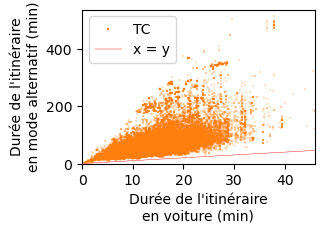

In [5]:
fig, ax = plt.subplots(figsize=(3, 2))
ax.scatter(merged["time_car_min"], merged["time_pt_min"], marker="+", s=1, alpha=.2, label="TC", c="C1")
ax.plot([0, max(x_max, y_max)], [0, max(x_max, y_max)], linewidth=.3, color="red", label="x = y", zorder=0)
ax.set_xlim(left=0, right=x_max)
ax.set_ylim(bottom=0, top=y_max)
legend = ax.legend()
for lh in legend.legend_handles: 
    lh.set_alpha(1)
ax.set_xlabel("Durée de l'itinéraire\nen voiture (min)")
ax.set_ylabel("Durée de l'itinéraire\nen mode alternatif (min)")
ax.set_rasterization_zorder(1)
plt.savefig("figures/comparaison_tc_voiture.pgf", dpi=150, bbox_inches='tight')

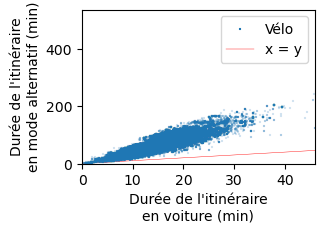

In [6]:
fig, ax = plt.subplots(figsize=(3, 2))
ax.scatter(merged["time_car_min"], merged["time_bike_min"], marker="+", s=1, alpha=.2, label="Vélo")
ax.plot([0, max(x_max, y_max)], [0, max(x_max, y_max)], linewidth=.3, color="red", label="x = y", zorder=0)
ax.set_xlim(left=0, right=x_max)
ax.set_ylim(bottom=0, top=y_max)
legend = ax.legend()
for lh in legend.legend_handles: 
    lh.set_alpha(1)
ax.set_xlabel("Durée de l'itinéraire\nen voiture (min)")
ax.set_ylabel("Durée de l'itinéraire\nen mode alternatif (min)")
ax.set_rasterization_zorder(1)
plt.savefig("figures/comparaison_velo_voiture.pgf", dpi=150, bbox_inches='tight')

In [7]:
def print_gh_url_from_journey(journey):
    olat = journey["journey_start_lat"]
    olon = journey["journey_start_lon"]
    dlat = journey["journey_end_lat"]
    dlon = journey["journey_end_lon"]
    time = pd.Timestamp.isoformat(journey["journey_end_datetime_norm"].tz_convert("UTC")).replace("+00:00", "Z")
    print(f"http://localhost:8989/maps/?profile=car&point={olat},{olon}&point={dlat},{dlon}&pt.arrive_by=true&pt.earliest_departure_time={time}")
    print(f"http://localhost:8989/route?profile=pt&point={olat},{olon}&point={dlat},{dlon}&pt.arrive_by=true&pt.earliest_departure_time={time}")

#print_gh_url_from_journey(merged.loc[407498])

In [8]:
pt_route_found = merged["transfers_pt"].ge(0)
legs_pt = merged.loc[pt_route_found, "legs_pt"].explode()
first_legs_pt = pd.json_normalize(legs_pt[~legs_pt.index.duplicated(keep="first")])
merged.loc[pt_route_found, "journey_start_datetime_pt"] = pd.to_datetime(first_legs_pt["departure_time"].values)
last_legs_pt = pd.json_normalize(legs_pt[~legs_pt.index.duplicated(keep="last")])
merged.loc[pt_route_found, "journey_end_datetime_pt"] = pd.to_datetime(last_legs_pt["arrival_time"].values)

merged.loc[pt_route_found, "pt_diff_start"] = (merged["journey_start_datetime_pt"] - merged["journey_start_datetime_norm"]).dt.total_seconds()
merged.loc[pt_route_found, "pt_diff_end"] = (merged["journey_end_datetime_pt"] - merged["journey_end_datetime_norm"]).dt.total_seconds()

(0.0, 80.83370288248337)

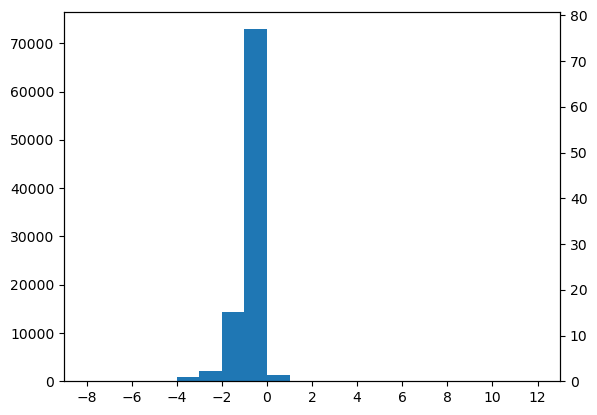

In [9]:
pt_diff_start_hours = merged["pt_diff_start"] / 3600
ax = plt.subplot()
ax.hist(pt_diff_start_hours, bins=np.arange(int(min(pt_diff_start_hours)), int(max(pt_diff_start_hours)) + 1))
ax.set_xticks(np.arange(int(min(pt_diff_start_hours)), int(max(pt_diff_start_hours)) + 2, 2))

ax2 = ax.twinx()
ax2.set_ylim(top=ax.get_ylim()[1] / merged.shape[0] * 100)

Text(0.5, 0, "Différence d'heure de départ (heures)")

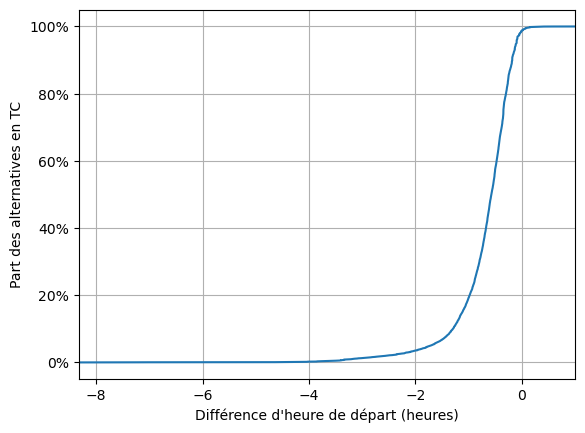

In [10]:
pt_diff_start_cumsum = merged["pt_diff_start"].value_counts(sort=False).sort_index().cumsum().reset_index()
x, y = pt_diff_start_cumsum.values.T 
count = pt_route_found.sum()
ax = plt.subplot()
ax.plot(x / 3600, y / count)
#ax.invert_xaxis()
ax.grid()
ax.margins(x=0)
ax.set_xlim(right=1) # 13 outsiders > 1h
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_ylabel("Part des alternatives en TC")
ax.set_xlabel("Différence d'heure de départ (heures)")

Text(0.5, 0, "Différence d'heure d'arrivée (minutes)")

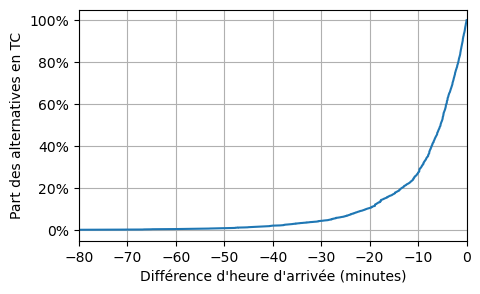

In [11]:
pt_diff_end_cumsum = merged["pt_diff_end"].value_counts(sort=False).sort_index().cumsum().reset_index()
x, y = pt_diff_end_cumsum.values.T
count = pt_route_found.sum()
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(x / 60, y / count)
#ax.invert_xaxis()
ax.grid()
ax.margins(x=0)
ax.set_xlim(left=-80, right=0)
ax.set_ylabel("Part des alternatives en TC")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_xlabel("Différence d'heure d'arrivée (minutes)")

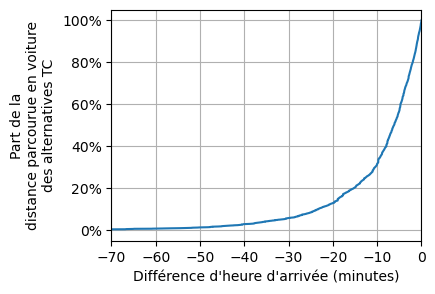

In [12]:
pt_diff_end_cumsum = merged.groupby("pt_diff_end")["distance_car"].sum().sort_index().cumsum().reset_index()
x, y = pt_diff_end_cumsum.values.T
tot_distance = merged.loc[pt_route_found, "distance_car"].sum()
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(x / 60, y / tot_distance)
ax.grid()
ax.margins(x=0)
ax.set_xlim(left=-70, right=0)
ax.set_ylabel("Part de la\ndistance parcourue en voiture\ndes alternatives TC")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_xlabel("Différence d'heure d'arrivée (minutes)")
plt.savefig("figures/rpc_tc_heure_arrivee.pgf", bbox_inches='tight')

# Heroic choice model

In [13]:
merged["journey_start_yearmonth"] = merged["journey_start_date"].str[:7]
merged["yearfixed"] = merged["journey_start_datetime"].dt.year
merged["weekfixed"] = merged["journey_start_datetime"].dt.strftime("%W")
merged.loc[merged["journey_start_datetime"].dt.strftime("%W").eq("00"), "yearfixed"] -= 1 # Fix year for week 0 (they belong to the year before)
merged.loc[merged["journey_start_datetime"].dt.strftime("%W").eq("00"), "weekfixed"] = 52 # Fix year for week 0 (they belong to the year before)
merged["journey_start_yearweek"] = merged["yearfixed"].astype(str) + "-" + merged["weekfixed"].astype(str)

Total: 94710
Chose bike: 9784 / 0.10330482525604477
Chose pt: 45389 / 0.47924189631506703


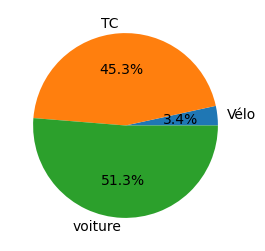

In [22]:
merged["chose_bike"] = merged["time_bike"].le(30 * 60 * 1000)
merged["chose_pt"] = merged["time_pt"].le(60 * 60 * 1000) & merged["pt_diff_end"].ge(-1800) & ~merged["chose_bike"]

scoped = merged[:]
print("Total:", scoped.shape[0])
print("Chose bike:", scoped["chose_bike"].sum(), "/", scoped["chose_bike"].sum() / scoped["chose_bike"].shape[0])
print("Chose pt:", scoped["chose_pt"].sum(), "/", scoped["chose_pt"].sum() / scoped["chose_pt"].shape[0])

fig, ax = plt.subplots(figsize=(3,3))
ax.pie([
    scoped.loc[scoped["chose_bike"], "distance_car"].sum(),
    scoped.loc[scoped["chose_pt"], "distance_car"].sum(),
    scoped.loc[~(scoped["chose_pt"] | scoped["chose_bike"]), "distance_car"].sum()
],
   labels=["Vélo", "TC", "voiture"], autopct='%1.1f%%')
plt.savefig("figures/resultat_modele_heroique.pgf", bbox_inches='tight')

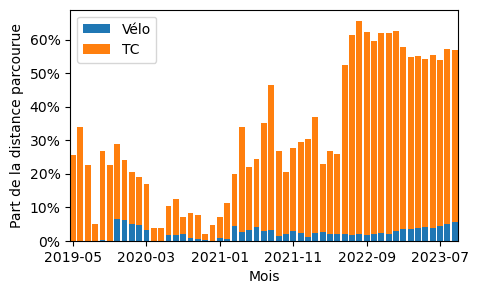

In [21]:
chose_bike_evol = merged.groupby("journey_start_yearmonth").apply(lambda x: x.loc[x["chose_bike"], "distance_car"].sum()/x["distance_car"].sum())
chose_pt_evol = merged.groupby("journey_start_yearmonth").apply(lambda x: x.loc[x["chose_pt"], "distance_car"].sum()/x["distance_car"].sum())

fig, ax = plt.subplots(figsize=(5,3))
ax.bar(chose_pt_evol.index.values, chose_bike_evol.values, label="Vélo")
bottom = chose_bike_evol.values
ax.bar(chose_pt_evol.index.values, chose_pt_evol.values, bottom=bottom, label="TC")
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.set_xlabel("Mois")
ax.set_ylabel("Part de la distance parcourue")
ax.margins(x=0)
ax.legend(loc="upper left")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.savefig("figures/resultat_modele_heroique_hist.pgf", bbox_inches='tight')

In [16]:
total_dist_per_month = merged.groupby(step)["distance_car"].sum()

bike_levels = [15, 25, 30]
bikable_levels = pd.concat([merged.loc[merged["time_bike"].le(value * MINUTES)].groupby(step)["distance_car"].sum().rename(level) for level, value in enumerate(bike_levels)], axis=1).fillna(0).sort_index()
bikable_levels_rel = bikable_levels.divide(total_dist_per_month, axis=0)

pt_levels = [30, 45, 60]
ptable_levels = pd.concat([merged.loc[merged["time_pt"].le(value * MINUTES) & merged["pt_diff_end"].ge(-1800)].groupby(step)["distance_car"].sum().rename(level) for level, value in enumerate(pt_levels)], axis=1).fillna(0).sort_index()
ptable_levels_rel = ptable_levels.divide(total_dist_per_month, axis=0)

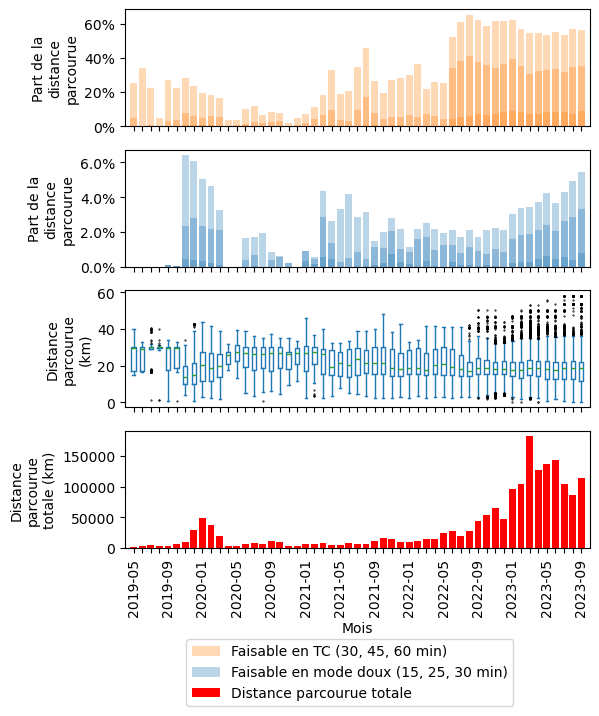

In [17]:
x = sorted(merged[step].unique())
avg_dist = merged.groupby(step)["journey_distance"].mean().values
std_dist = merged.groupby(step)["journey_distance"].std().values
bstd_dist = avg_dist - std_dist
tstd_dist = avg_dist + std_dist

fig, axes = plt.subplots(4, 1, figsize=(6, 7))
axpt, axsoft, axavg, axtot = axes
axsoft.bar(x, bikable_levels_rel[0].values, alpha=.3, facecolor="C0", label="Faisable en mode doux (15, 25, 30 min)")
axsoft.bar(x, bikable_levels_rel[1].values, alpha=.3, facecolor="C0")
axsoft.bar(x, bikable_levels_rel[2].values, alpha=.3, facecolor="C0")
axsoft.set_ylim(bottom=0)
axsoft.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
axsoft.set_ylabel("Part de la\ndistance\nparcourue")

axpt.bar(x, ptable_levels_rel[0].values, alpha=.3, facecolor="C1", label="Faisable en TC (30, 45, 60 min)")
axpt.bar(x, ptable_levels_rel[1].values, alpha=.3, facecolor="C1")
axpt.bar(x, ptable_levels_rel[2].values, alpha=.3, facecolor="C1")
axpt.set_ylim(bottom=0)
axpt.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
axpt.set_ylabel("Part de la\ndistance\nparcourue")

tot_dist = merged.groupby(step)["journey_distance"].sum().values
axtot.bar(x, tot_dist / 1000, color="red", label="Distance parcourue totale")
axtot.set_ylabel("Distance\nparcourue\ntotale (km)")
axtot.set_ylim(bottom=0)

merged["journey_distance_km"] = merged["journey_distance"] / 1000
merged.plot(kind="box", column="journey_distance_km", by=step, flierprops={"markersize": .5}, xlabel="", ylabel="Distance\nparcourue\n(km)", title="", ax=axavg, zorder= -1)
axavg.tick_params(axis="x", rotation=90)
axavg.set_title("")
axavg.set_rasterization_zorder(0)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01))

for ax in axes[:-1]:
    ax.xaxis.set_ticklabels([])

for ax in axes:
    ax.set_xlim(left=-1, right=len(x))
    # ax.set_axisbelow(True)
    # ax.grid(True, axis="y", zorder=-1)

axavg.set_xlim(left=0, right=len(x)+1)

axes[-1].tick_params(axis='x', labelrotation=90)
axes[-1].set_xlabel("Mois")
[l.set_visible(False) for (i,l) in enumerate(axes[-1].xaxis.get_ticklabels()) if i % 4 != 0];
plt.savefig("figures/rpc_isere_heroic_stats.pgf", bbox_inches='tight', dpi=150)

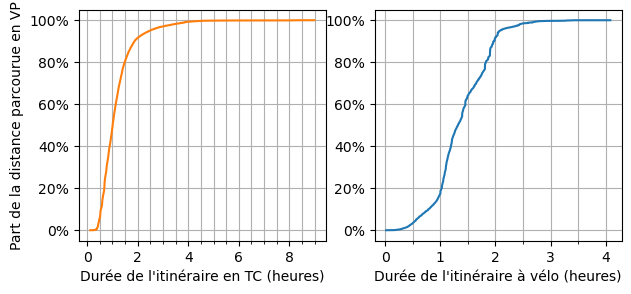

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
ax_l, ax_r = axes


merged["time_pt_hours"] = merged["time_pt"] / (60 * MINUTES)
cs = merged[pt_route_found].groupby("time_pt_hours")["distance_car"].sum().cumsum()
cs.divide(cs.values[-1]).plot(ax=ax_l, color="C1")
ax_l.set_xlabel("Durée de l'itinéraire en TC (heures)")
ax_l.set_ylabel("Part de la distance parcourue en VP")

merged["time_bike_hour"] = merged["time_bike"] / (60 * MINUTES)
cs = merged.groupby("time_bike_hour")["distance_car"].sum().cumsum()
cs.divide(cs.values[-1]).plot(ax=ax_r)
ax_r.set_xlabel("Durée de l'itinéraire à vélo (heures)")

for ax in axes:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.xaxis.set_minor_locator(mtick.MultipleLocator(.5))
    ax.grid(which="both")
plt.savefig("figures/rpc_isere_abs_velo_tc.pgf", bbox_inches='tight')

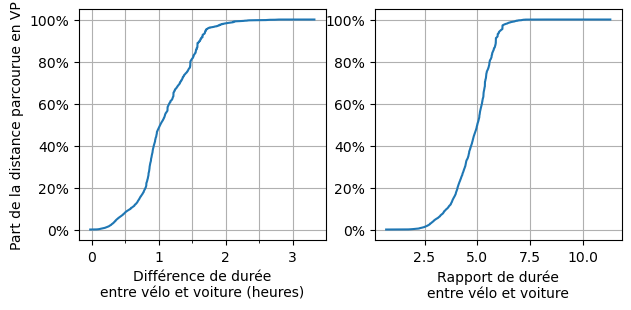

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
ax_l, ax_r = axes

merged["diff_bike"] = (merged["time_bike"] - merged["time_car"]) / (60 * MINUTES)
cumsum = merged.groupby("diff_bike")["distance_car"].sum().cumsum()
cumsum.divide(cumsum.values[-1]).plot(ax=ax_l)
ax_l.set_xlabel("Différence de durée\nentre vélo et voiture (heures)")
ax_l.xaxis.set_minor_locator(mtick.MultipleLocator(.5))
ax_l.set_ylabel("Part de la distance parcourue en VP")

merged["ratio_bike"] = merged["time_bike"] / merged["time_car"]
cumsum = merged.groupby("ratio_bike")["distance_car"].sum().cumsum()
cumsum.divide(cumsum.values[-1]).plot(ax=ax_r)
ax_r.set_xlabel("Rapport de durée\nentre vélo et voiture")
#ax_r.xaxis.set_minor_locator(mtick.MultipleLocator(.5))

for ax in axes:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.grid(which="both")
plt.savefig("figures/rpc_isere_velo_rel.pgf", bbox_inches='tight')

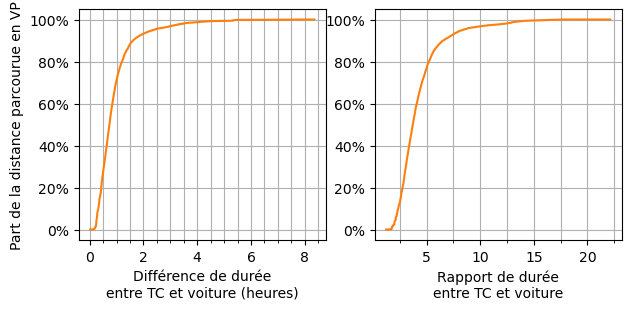

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
ax_l, ax_r = axes

merged["diff_pt"] = (merged["time_pt"] - merged["time_car"]) / (60 * MINUTES)
cumsum = merged.groupby("diff_pt")["distance_car"].sum().cumsum()
cumsum.divide(cumsum.values[-1]).plot(ax=ax_l, color="C1")
ax_l.set_xlabel("Différence de durée\nentre TC et voiture (heures)")
ax_l.xaxis.set_minor_locator(mtick.MultipleLocator(.5))
ax_l.set_ylabel("Part de la distance parcourue en VP")

merged["ratio_pt"] = merged["time_pt"] / merged["time_car"]
cumsum = merged.groupby("ratio_pt")["distance_car"].sum().cumsum()
cumsum.divide(cumsum.values[-1]).plot(ax=ax_r, color="C1")
ax_r.set_xlabel("Rapport de durée\nentre TC et voiture")
ax_r.xaxis.set_minor_locator(mtick.MultipleLocator(2.5))

for ax in axes:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.grid(which="both")
plt.savefig("figures/rpc_isere_tc_rel.pgf", bbox_inches='tight')